# Visión por Computadora
### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

# Task 1

**Prompt usado:**

> Estoy documentando un procedimiento de procesamiento de imágenes para reducir un patrón periódico visible en una fotografía. Sugiere un flujo de trabajo basado en Fourier para inspeccionar el espectro, localizar componentes anómalos y aplicar un filtrado selectivo, incluyendo visualizaciones recomendadas y un ejemplo de implementación en Python.

In [204]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["image.cmap"] = "gray"

## Cargar la imagen periodic_noise.jpg

Imagen: (512, 512) uint8


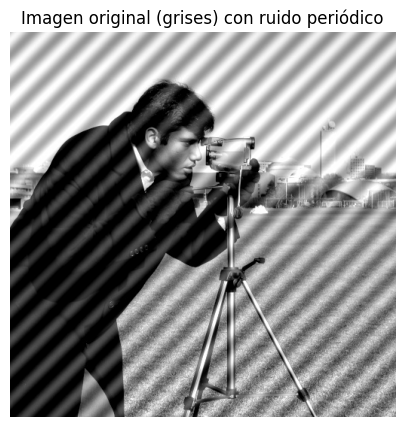

In [205]:

img_path = "./imgs/periodic_noise.jpg"

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(
        f"No se pudo leer '{img_path}'. "
        "Asegúrate de que esté en la misma carpeta del notebook o ajusta img_path."
    )

rows, cols = img.shape
cy, cx = rows // 2, cols // 2

print("Imagen:", img.shape, img.dtype)

plt.figure()
plt.title("Imagen original (grises) con ruido periódico")
plt.imshow(img)
plt.axis("off")
plt.show()


## DFT y centrado del componente DC

Usé `cv2.dft(..., DFT_COMPLEX_OUTPUT)` porque es la ruta típica utilizando OpenCV.
Luego apliqué `fftshift` (sobre ejes espaciales) para ubicar DC en el centro y facilitar la inspección visual.

In [206]:
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

# Desplazar DC al centro (solo ejes 0 y 1)
dft_shift = np.fft.fftshift(dft, axes=(0, 1))


## Epectro de magnitud en escala logarítmica

El espectro tiene rango dinámico grande, por lo que usé `log(1 + |F|)` para ver aquellos picos débiles y fuertes dentro de una misma imagen.

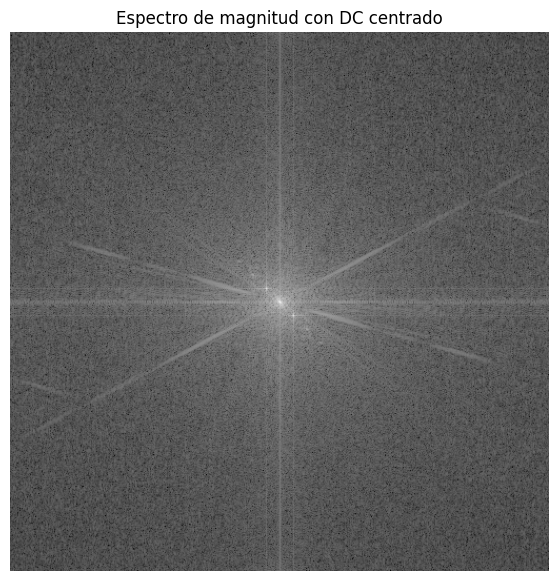

In [207]:

magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
mag_log = np.log1p(magnitude)

plt.figure(figsize=(7, 7))
plt.title("Espectro de magnitud con DC centrado")
plt.imshow(mag_log)
plt.axis("off")
plt.show()


## identificamos los picos de energía del ruido

El ruido sinusoidal aparece como picos brillantes (fuera del centro). Para detectarlos de forma reproducible:

1) Excluí un radio alrededor del centro (para no confundir DC y energía natural dominante).
2) Umbralizé por percentil alto para quedarme con picos.
3) Agrupé con componentes conectados y tomamos sus centroides.


Picos seleccionados (x, y):
[[269 269]
 [243 243]
 [239 243]
 [273 269]
 [215 244]
 [297 268]
 [237 268]
 [275 244]]


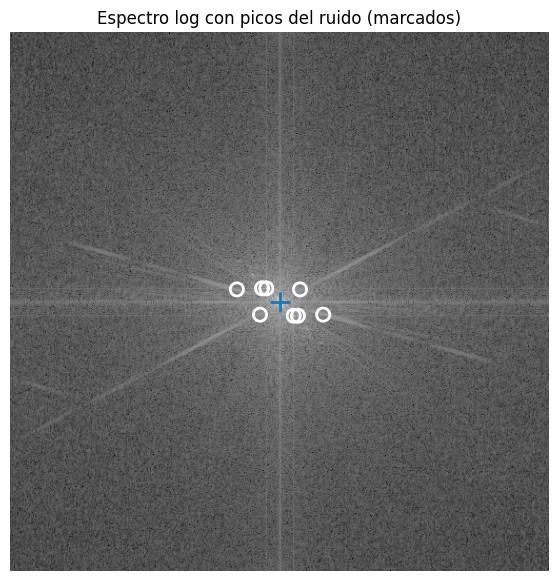

In [ ]:
exclude_radius = 12    # radio que se excluye alrededor de DC
percentile = 99.8      # percentil alto para capturar picos brillantes
top_k = 20             # máximo de picos a conservar
morph_ksize = 3        # limpieza morfológica

# Máscara para excluir el centro
Y, X = np.ogrid[:rows, :cols]
dist2_center = (Y - cy)**2 + (X - cx)**2
allowed = dist2_center > (exclude_radius**2)

mag_supp = mag_log * allowed.astype(np.float32)

# Umbral por percentil
vals = mag_supp[allowed]
thr = np.percentile(vals, percentile) if vals.size else 0.0

binary = (mag_supp >= thr).astype(np.uint8) * 255

# Limpieza morfológica lo que reduce falsos positivos
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ksize, morph_ksize))
binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, k, iterations=1)

# Para agrupar picos
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_clean, connectivity=8)

# Centroides
centroids = centroids[1:]  

if centroids.size == 0:
    print("No se detectaron picos con los parámetros actuales.")
    peak_xy = np.empty((0, 2), dtype=np.int32)
else:
    # Convertir centroides a índices enteros válidos
    peak_xy = np.rint(centroids).astype(np.int32) 
    peak_xy[:, 0] = np.clip(peak_xy[:, 0], 0, cols - 1)
    peak_xy[:, 1] = np.clip(peak_xy[:, 1], 0, rows - 1)

    # Intensidad en el espectro log para ordenar
    intens = mag_log[peak_xy[:, 1], peak_xy[:, 0]]

    # Ordenar por intensidad descendente y recortar top_k
    order = np.argsort(intens)[::-1]
    peak_xy = peak_xy[order][:top_k]

print("Picos seleccionados (x, y):")
print(peak_xy)

# Visualización con picos marcados
plt.figure(figsize=(7, 7))
plt.title("Espectro log con picos del ruido (marcados)")
plt.imshow(mag_log)
if peak_xy.size:
    plt.scatter(peak_xy[:, 0], peak_xy[:, 1], s=90, facecolors="none", edgecolors="white", linewidths=2)
plt.scatter([cx], [cy], marker="+", s=200, linewidths=2)
plt.axis("off")
plt.show()


## Máscara de Notch

En vez de un pasa-bajas global (suavizado), anulé solo las frecuencias parásitas (bandas estrechas) con discos alrededor de cada pico.

para la implementación vectorizada se calculó una condición de pertenencia al disco usando broadcasting y luego bloqueamos donde corresponda.

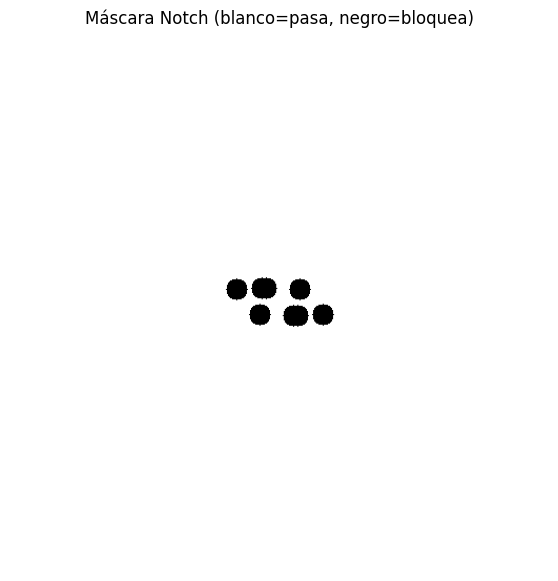

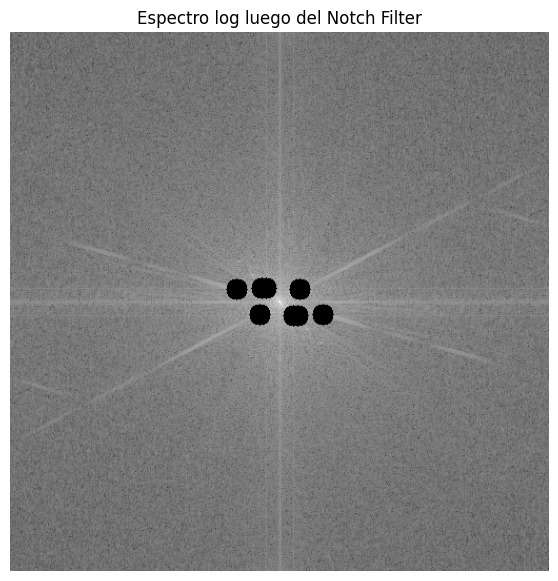

In [209]:

notch_radius = 10

mask = np.ones((rows, cols), dtype=np.float32)

if peak_xy.size:
    # Construcción vectorizada de discos alrededor de cada pico
    # peak_xy: (n, 2) -> x,y
    px = peak_xy[:, 0].astype(np.float32)[:, None, None]
    py = peak_xy[:, 1].astype(np.float32)[:, None, None]

    # Grillas (1,rows,cols)
    YY = Y.astype(np.float32)[None, :, :]
    XX = X.astype(np.float32)[None, :, :]

    dist2 = (YY - py)**2 + (XX - px)**2 
    blocked = np.any(dist2 <= (notch_radius**2), axis=0)

    mask = mask * (~blocked).astype(np.float32)

# Preservar DC
mask[cy, cx] = 1.0

# Máscara de 2 canales para multiplicar la DFT compleja
mask2 = np.repeat(mask[:, :, None], 2, axis=2)

plt.figure(figsize=(7, 7))
plt.title("Máscara Notch (blanco=pasa, negro=bloquea)")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

# Aplicar máscara en el dominio de Fourier
dft_shift_filt = dft_shift * mask2

plt.figure(figsize=(7, 7))
plt.title("Espectro log luego del Notch Filter")
plt.imshow(np.log1p(cv2.magnitude(dft_shift_filt[:, :, 0], dft_shift_filt[:, :, 1])))
plt.axis("off")
plt.show()


## IDFT para reconstrucción espacial

Invertí el corrimiento (`ifftshift`) y aplicamos `cv2.idft`. Después, visualicé el resultado para la comparación.

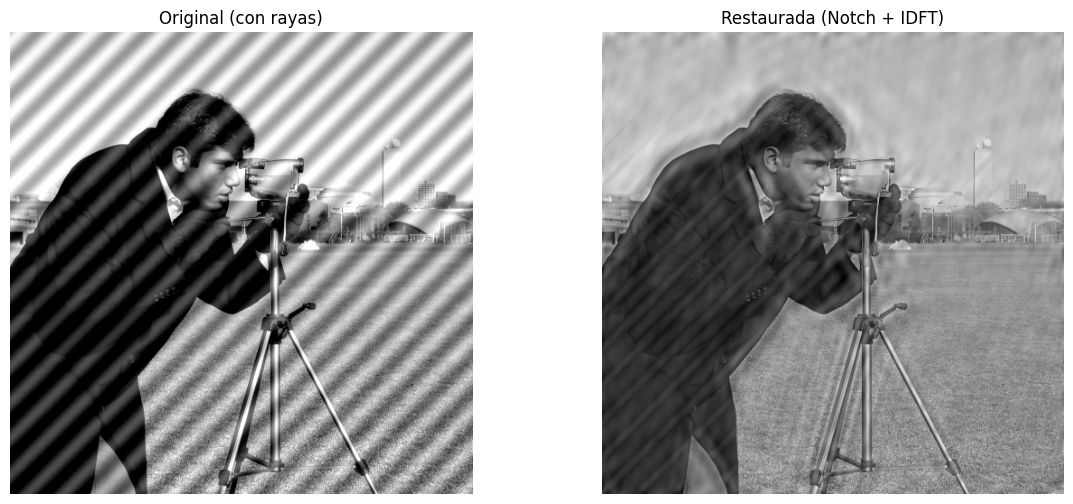

In [210]:

# Volver a ubicar DC en esquina (para IDFT)
dft_ishift = np.fft.ifftshift(dft_shift_filt, axes=(0, 1))

# IDFT
img_back_complex = cv2.idft(dft_ishift)
img_back = cv2.idft(dft_ishift, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

# Normalizar para visualización
img_back_u8 = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Original (con rayas)")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Restaurada (Notch + IDFT)")
plt.imshow(img_back_u8)
plt.axis("off")
plt.show()
